# **Project: Time Series Forecasting.**
---

#### Objective: Developing LSTM model with an attention mechanism to forecast hourly Air PM 2.5 concentrations & comparing against traditional Prophet model.


### **Dataset: Beijing PM 2.5 Data (UCI Machine Learning Repository, 2010-2014).**

In [ ]:
# Importing Essential Libraries.

# Standard Operation.
import os
import pandas as pd
import numpy as np

# For Visualizations.
import matplotlib.pyplot as plt
import seaborn as sns

# For Preprocessing and Metrics.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For Deep Learning.
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For Optimization.
import torch.optim as optim

# Time Series Comparison.
from prophet import Prophet

# Utilities.
import requests
from io import StringIO

print ("Importing essential libraries are now completed.")

Importing essential libraries are now completed.


In [ ]:
# Project Configuration & Constants.

# Sequence & Model Parameters.
N_PAST_HOURS = 24
N_FUTURE_HOURS = 1
TARGET_COL_NAME = 'pm2.5'

# Training Parameters.
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
TRAIN_TEST_RATIO = 0.8

# File & Directory Paths.
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
MODELS_DIR = "trained_models"
LSTM_MODEL_PATH = os.path.join(MODELS_DIR, "lstm_attention_pm25_model.keras")

os.makedirs(MODELS_DIR, exist_ok=True)

# Reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print ("Project configuration & Data gatherings are now completed.")

Project configuration & Data gatherings are now completed.


In [ ]:
# Data Acquisition.

df_raw = None
try:
    response = requests.get(DATASET_URL, timeout=30)
    response.raise_for_status()
    df_raw = pd.read_csv(StringIO(response.text))
    print("Dataset successfully downloaded & loaded.")
except Exception as e:
    print(f"Data could not be loaded, {e}")


if df_raw is not None:
    # Display a concise summary of the raw data
    df_raw.info()
    print(f"Missing PM 2.5 values, {df_raw['pm2.5'].isnull().sum()}")

Dataset successfully downloaded & loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
Missing PM 2.5 values, 2067


## Step 1: **Data Preprocessing.**

In [ ]:
if df_raw is not None:
    df = df_raw.copy()

    # Forward fill - Backward fill strategy.
    df[TARGET_COL_NAME] = df[TARGET_COL_NAME].ffill().bfill()

    # Creating datetime index from year, month, day, hour columns.
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df.set_index('datetime', inplace=True)

    # One-hot encode combined wind direction (cbwd).
    df = pd.get_dummies(df, columns=['cbwd'], prefix='wind', dummy_na=False)

    # Cyclical features for time components.
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 23.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 23.0)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 6.0)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 6.0)

    # Defining feature set.
    core_features = [TARGET_COL_NAME, 'DEWP', 'TEMP', 'PRES', 'Iws']
    time_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    wind_features = [col for col in df.columns if 'wind_' in col]
    final_features_list = core_features + time_features + wind_features

    df_processed = df[final_features_list].copy()

    # Final cleanup for any residual NaNs.
    df_processed.dropna(inplace=True)

    print("Processed feature set is ready.")
    print(f"Processed data: {df_processed.shape}")
    print("Final features:", final_features_list)
else:
    print("Raw data not available.")

Processed feature set is ready.
Processed data: (43824, 13)
Final features: ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv']


In [ ]:
# Data Scaling & Sequencing.

def create_lstm_sequences(data_array, n_past, n_future, target_idx):
    X, y = [], []
    for i in range(n_past, len(data_array) - n_future + 1):
        X.append(data_array[i - n_past:i, :])
        y.append(data_array[i + n_future - 1:i + n_future, target_idx])
    return np.array(X), np.array(y)


if 'df_processed' in locals() and not df_processed.empty:

    # Scaler feature.
    feature_scaler = MinMaxScaler()
    scaled_feature_data = feature_scaler.fit_transform(df_processed)


    # Creating separate scaler to allow correct inverse transformation.
    target_scaler = MinMaxScaler()
    target_scaler.fit(df_processed[[TARGET_COL_NAME]])

    # Creating Sequences.
    target_col_idx = df_processed.columns.get_loc(TARGET_COL_NAME)
    X_sequences, y_sequences = create_lstm_sequences(scaled_feature_data, N_PAST_HOURS, N_FUTURE_HOURS, target_col_idx)

    # Spliting data chronologically.
    split_index = int(len(X_sequences) * TRAIN_TEST_RATIO)
    X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
    y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

    print(f"Data successfully scaled & sequenced.")
    print(f"Training set shape: X = {X_train.shape}, y = {y_train.shape}")
    print(f"Test set shape: X = {X_test.shape}, y = {y_test.shape}")

    # Defining model input shapes.
    N_TIMESTEPS_MODEL = X_train.shape[1]
    N_FEATURES_MODEL = X_train.shape[2]

else:
    print("Skipping scaling & sequencing. Processed data not available.")

Data successfully scaled & sequenced.
Training set shape: X = (35040, 24, 13), y = (35040, 1)
Test set shape: X = (8760, 24, 13), y = (8760, 1)


## Step 2: **Model Architecture.**

In [ ]:
# Building sequential LSTM Model with Attention Mechanism.

# Defining custom layer.
class SimpleAttention(Layer):
    def init(self, kwargs):
        super().init(kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_W", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_b", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output

    def get_config(self): return super().get_config()


if 'N_TIMESTEPS_MODEL' in locals():
    lstm_model = Sequential([
        Input(shape=(N_TIMESTEPS_MODEL, N_FEATURES_MODEL)), LSTM(128, return_sequences=True), Dropout(0.25), LSTM(64, return_sequences=True), Dropout(0.25), SimpleAttention(), Dense(64, activation='relu'),
        Dropout(0.25), Dense(N_FUTURE_HOURS)])
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    lstm_model.summary()
else:
    print("Skipping model definition, input shapes not determined.")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 24, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention_4              │ (None, 64)             │         4,224 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,561 (510.00 KB)

 Trainable params: 130,561 (510.00 KB)

 Non-trainable params: 0 (0.00 B)

## Step 3: **Model Training.**

Initiating LSTM model training.
Epoch 1/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 58s 55ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 2/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 55s 56ms/step - loss: 0.0020 - val_loss: 6.9725e-04
Epoch 3/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 80s 54ms/step - loss: 0.0013 - val_loss: 5.2660e-04
Epoch 4/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 0.0010 - val_loss: 5.9023e-04
Epoch 5/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 9.3060e-04 - val_loss: 5.4673e-04
Epoch 6/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 84s 57ms/step - loss: 8.9358e-04 - val_loss: 4.1362e-04
Epoch 7/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 54s 55ms/step - loss: 8.6686e-04 - val_loss: 4.8732e-04
Epoch 8/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 8.5829e-04 - val_loss: 4.3815e-04
Epoch 9/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - loss: 8.1846e-04 - val_loss: 4.8336e-04
Epoch 10/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 8.3053e-04 - val_loss: 5.1469e-04
Epoch 11/100
986/

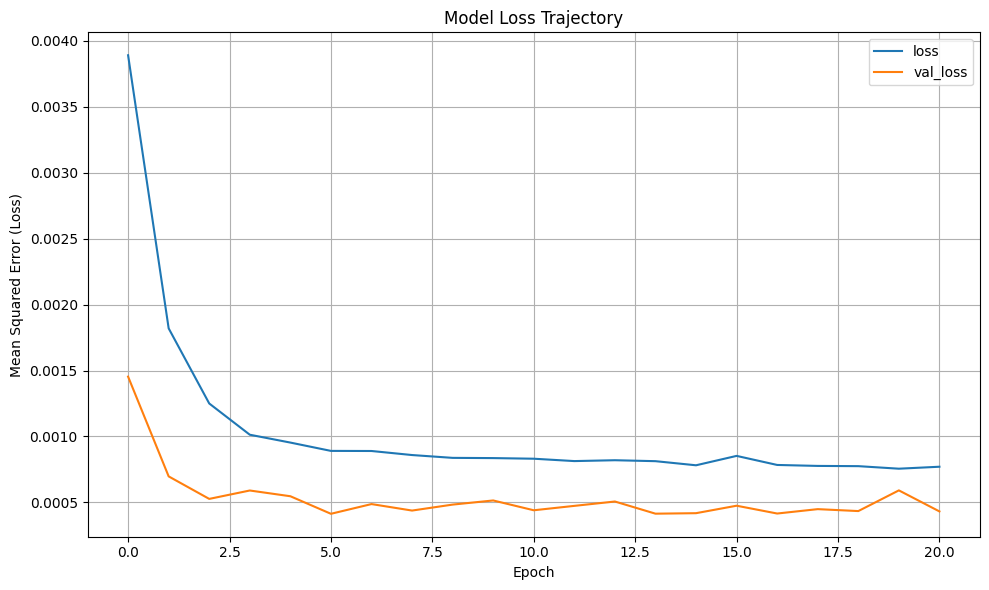

In [41]:
if 'lstm_model' in locals() and 'X_train' in locals() and X_train.size > 0:
    callbacks_list = [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1), ModelCheckpoint(filepath=LSTM_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=0)]

    print("Initiating LSTM model training.")
    history = lstm_model.fit( X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=callbacks_list, verbose=1)
    print("LSTM model training completed.")

    # Plotting training history.
    pd.DataFrame(history.history).plot(figsize=(10, 6))
    plt.title("Model Loss Trajectory")
    plt.ylabel("Mean Squared Error (Loss)")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Skipped training as Model or Training data not available.")

# Step 4: **Model Evaluation.**

274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
LSTM model test set evaluation.
RMSE: 21.616 | MAE: 13.315 | MAPE: 35.42%


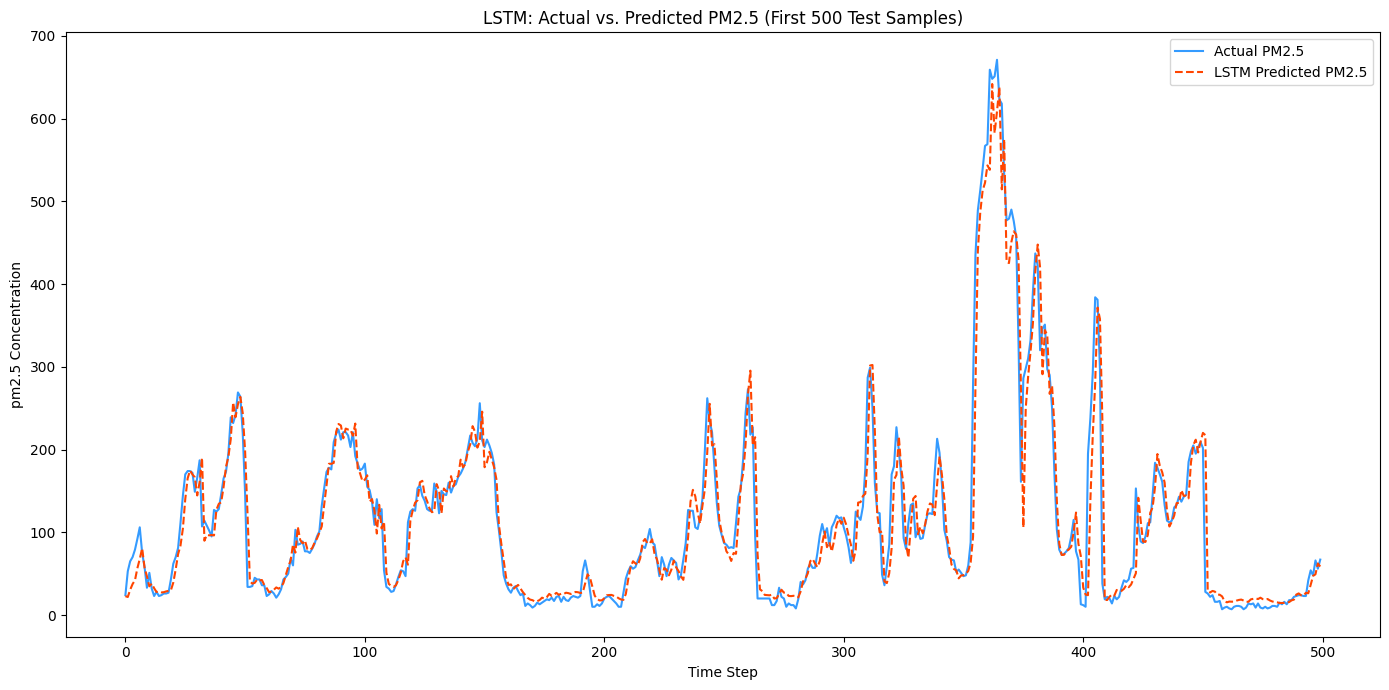

In [42]:
def compute_evaluation_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
    return rmse, mae, mape

if 'X_test' in locals() and os.path.exists(LSTM_MODEL_PATH):
    best_model_loaded = load_model(LSTM_MODEL_PATH, custom_objects={'SimpleAttention': SimpleAttention})

    y_pred_scaled = best_model_loaded.predict(X_test)

    # Inverse transforming to original PM 2.5 scale.
    y_pred_actual = target_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = target_scaler.inverse_transform(y_test)

    lstm_rmse, lstm_mae, lstm_mape = compute_evaluation_metrics(y_test_actual, y_pred_actual)
    print("LSTM model test set evaluation.")
    print(f"RMSE: {lstm_rmse:.3f} | MAE: {lstm_mae:.3f} | MAPE: {lstm_mape:.2f}%")

    # Visualization of predictions vs actual.
    plt.figure(figsize=(14, 7))
    plot_points = min(500, len(y_test_actual))
    plt.plot(y_test_actual[:plot_points], label='Actual PM2.5', color='dodgerblue', alpha=0.9)
    plt.plot(y_pred_actual[:plot_points], label='LSTM Predicted PM2.5', color='orangered', linestyle='--')
    plt.title(f'LSTM: Actual vs. Predicted PM2.5 (First {plot_points} Test Samples)')
    plt.xlabel('Time Step'); plt.ylabel(f'{TARGET_COL_NAME} Concentration'); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Skipping evaluation, Test data not available.")

## Step 5: **Comparative Analysis - Prophet**

In [43]:
if 'df' in locals():
    print("Comparision with prophet on hourly data.")
    prophet_df = df[[TARGET_COL_NAME]].reset_index().rename(columns={'datetime': 'ds', TARGET_COL_NAME: 'y'}).ffill().bfill()

    n_test_hours = int(len(prophet_df) * (1 - TRAIN_TEST_RATIO))
    train_prophet = prophet_df.iloc[:-n_test_hours]
    test_prophet_actuals = prophet_df.iloc[-n_test_hours:]

    try:
        prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        prophet_model.fit(train_prophet)

        future_df = test_prophet_actuals[['ds']]
        prophet_forecast = prophet_model.predict(future_df)

        prophet_rmse, prophet_mae, prophet_mape = compute_evaluation_metrics(test_prophet_actuals['y'].values, prophet_forecast['yhat'].values)
        print(f"Prophet hourly, RMSE: {prophet_rmse:.3f} | MAE: {prophet_mae:.3f} | MAPE: {prophet_mape:.2f}%")
    except Exception as e:
        print(f"Prophet modeling failed, {e}")

Comparision with prophet on hourly data.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2p_57o72/jobt65pq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2p_57o72/78pngee7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22984', 'data', 'file=/tmp/tmp2p_57o72/jobt65pq.json', 'init=/tmp/tmp2p_57o72/78pngee7.json', 'output', 'file=/tmp/tmp2p_57o72/prophet_modelnjeepa7y/prophet_model-20250608152246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet hourly, RMSE: 99.663 | MAE: 67.102 | MAPE: 120.96%
